# Dependências

In [38]:
!pip install logitboost
!pip install wittgenstein
!pip install python-javabridge
!pip install python-weka-wrapper3

from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from logitboost import LogitBoost
import numpy as np
import pandas as pd
import seaborn as sns
import wittgenstein as lw

import weka.core.jvm as jvm
from weka.classifiers import Classifier
from weka.core.dataset import create_instances_from_matrices
from weka.filters import Filter
from sklearn import metrics
from google.colab import drive

jvm.start()

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


# Obtenção do Dataset

In [39]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Faculdade/malware-hunter/Notebooks/ORIGINAL_Drebin215 (2012).csv'
drebin_df = pd.read_csv(dataset_path, sep=';')
X, y = drebin_df.iloc[:,:-1], drebin_df.iloc[:,-1]
y = np.array([1 if value == 'B' else 0 for value in y ]) # benigno = 1, malware = 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Execução do experimento

### Observação

Os seguintes algoritmos utilizados no paper possuem implementação na ferramenta Weka, mas não no Scikit-learn: Sequential Minimal Optimization (SMO), AdaBoostM1 e Random Committee. Portanto, vamos usar a biblioteca `python-weka-wrapper3` para eles. No caso do SMO, deve haver um classificador para cada kernel usado no paper, a saber, kernel polinomial, kernel normalizado, kernel PUK e kernel RBF.

In [42]:
class WekaClassifier:
    def __init__(self, classifier, prediction_threshold=0.6):
        self.classifier = classifier
        self.threshold = prediction_threshold
    
    def fit(self, X, y):
        train_data = create_instances_from_matrices(np.array(X), np.array(y))
        train_data = WekaClassifier.__convert_numeric_instances_to_nominal(train_data)
        train_data.class_is_last()
        self.classifier.build_classifier(train_data)
    
    def predict(self, X, y):
        test_data = create_instances_from_matrices(np.array(X), np.array(y))
        test_data = WekaClassifier.__convert_numeric_instances_to_nominal(test_data)
        test_data.class_is_last()
        y_pred = [self.classifier.classify_instance(instance) for instance in test_data]
        if(len(set(y_pred)) > 2):
            y_pred = [0 if prob > self.threshold else 1 for prob in y_pred]
        return y_pred

    def __convert_numeric_instances_to_nominal(instances):
        numeric_to_nominal = Filter("weka.filters.unsupervised.attribute.NumericToNominal")
        numeric_to_nominal.inputformat(instances)
        return numeric_to_nominal.filter(instances)

def run_experiment(X, y, classifiers, 
                   score_functions=[chi2, f_classif], 
                   n_folds=10, 
                   prediction_threshold=0.6, 
                   k_increment=20,
                   k_list=[]):
    """
    Esta função implementa um experimento de classificação binária usando validação cruzada e seleção de características. 
    Os "classifiers" devem implementar as funções "fit" e "predict", como as funções do Scikit-learn.
    Se a função "predict(X)" não retornar valores binários, então utiliza-se um esquema de predição baseada no limiar "prediction_threshold".
    Se o parâmetro "k_list" for uma lista não vazia, então ele será usado como a lista das quantidades de características a serem selecionadas. 
    """
    results = []
    if(len(k_list) > 0):
        k_values = k_list
    else:
        k_values = range(10, X.shape[1], k_increment)
    for k in k_values:
        if(k > X.shape[1]):
            continue
        print("K =", k)
        for score_function in score_functions:
            X_selected = SelectKBest(score_func=score_function, k=k).fit_transform(X, y)
            kf = KFold(n_splits=n_folds, random_state=256, shuffle=True)
            fold = 0
            for train_index, test_index in kf.split(X_selected):
                X_train, X_test = X_selected[train_index], X_selected[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                for classifier_name, classifier in classifiers.items():
                    classifier.fit(X_train, y_train)
                    if(isinstance(classifier, WekaClassifier)):
                        y_pred = classifier.predict(X_test, y_test)
                    else:
                        y_pred = classifier.predict(X_test)
                    report = classification_report(y_test, y_pred, output_dict=True)
                    results.append({'n_fold': fold,
                                    'k': k,
                                    'score_function':score_function.__name__,
                                    'algorithm': classifier_name,
                                    'accuracy': report['accuracy'],
                                    'precision': report['macro avg']['precision'], 
                                    'recall': report['macro avg']['recall'],
                                    'f-measure': report['macro avg']['f1-score']
                                })
                fold += 1
            
    return pd.DataFrame(results)


In [ ]:
classifiers = {
    'NaiveBayes': GaussianNB(),
    'KNN': KNeighborsClassifier(metric='euclidean'),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'SimpleLogistic': LogitBoost(),
    'JRIP': lw.RIPPER(),
    'SMO-PolyKernel' : WekaClassifier(Classifier("weka.classifiers.functions.SMO", options=['-K', 'weka.classifiers.functions.supportVector.PolyKernel'])),
    'SMO-NormalizedPolyKernel': WekaClassifier(Classifier("weka.classifiers.functions.SMO", options=['-K', 'weka.classifiers.functions.supportVector.NormalizedPolyKernel'])),
    'SMO-Puk': WekaClassifier(Classifier("weka.classifiers.functions.SMO", options=['-K', 'weka.classifiers.functions.supportVector.Puk'])),
    'SMO-RBFKernel': WekaClassifier(Classifier("weka.classifiers.functions.SMO", options=['-K', 'weka.classifiers.functions.supportVector.RBFKernel'])),
    'AdaBoostM1': WekaClassifier(Classifier("weka.classifiers.meta.AdaBoostM1")),
    'RandomCommittee':  WekaClassifier(Classifier("weka.classifiers.meta.RandomCommittee"))
}
results = run_experiment(X, y, classifiers, n_folds=3)

# Plot dos resultados

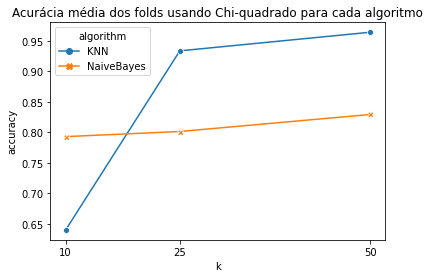

In [55]:
def plot_algorithms_results(results, title, score_function='chi2', metric='accuracy'):
    g = sns.lineplot(x='k', y=metric, hue='algorithm',
                    data=results[results['score_function'] == score_function].groupby(['k','algorithm']).mean(),
                    markers=True, style='algorithm', dashes=False)
    g.set_title(title)
    g.set_xticks(results['k'].unique())

plot_algorithms_results(results, 'Acurácia média dos folds usando Chi-quadrado para cada algoritmo')

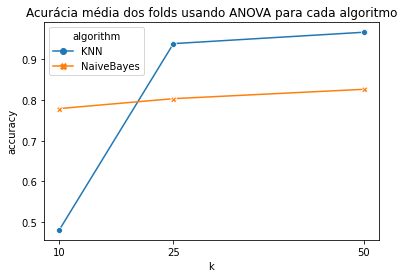

In [56]:
plot_algorithms_results(results, 'Acurácia média dos folds usando ANOVA para cada algoritmo', score_function='f_classif')